A2a Research Assignment 02 - Part 1

Import packages needed

In [45]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [46]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

Verify TensorFlow Version and Keras Version

In [47]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.7.0


In [48]:
print("Keras version: ", keras.__version__)

Keras version:  2.7.0


Mount Google Drive to Colab Environment

In [49]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Functions for Research Assignment

In [50]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [51]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

In [52]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).

x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).

y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

EDA Training and Test Datasets

Imported 50000 examples for training and 10000 examples for test

Imported 50000 labels for training and 10000 labels for test

In [53]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


Review labels for training dataset

In [54]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


Plot Examples

In [55]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [56]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [57]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

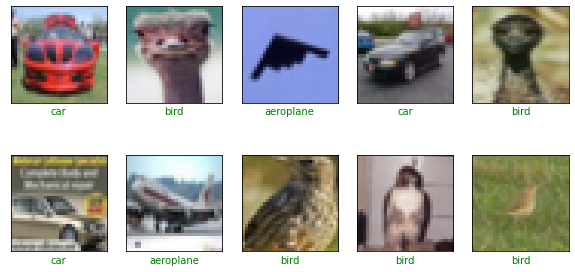

In [58]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)


Preprocessing Data for Model Development
The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

Label	Class_

0	airplane

1	automobile

2	bird

3	cat

4	deer

5	dog

6	frog

7	horse

8	ship

9	truck


In [59]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

Create Validation Data Set

In [60]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

Confirm Datasets {Train, Validation, Test}

In [61]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


Rescale Examples {Train, Validation, Test}

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255

Each element in each example is a pixel value

Pixel values range from 0 to 255

0 = black

255 = white

In [62]:
x_train_norm = x_train_split/255

x_valid_norm = x_valid_split/255

x_test_norm = x_test/255

Build CNN Model

We use a Sequential class defined in Keras to create our model. 

The first 9 layers Conv2D MaxPooling, Dropout handle feature learning. 

The last 3 layers, handle classification

In [63]:
model = models.Sequential()
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D((2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.Dense(units=10, activation=tf.nn.softmax))


In [64]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 6, 6, 256)        

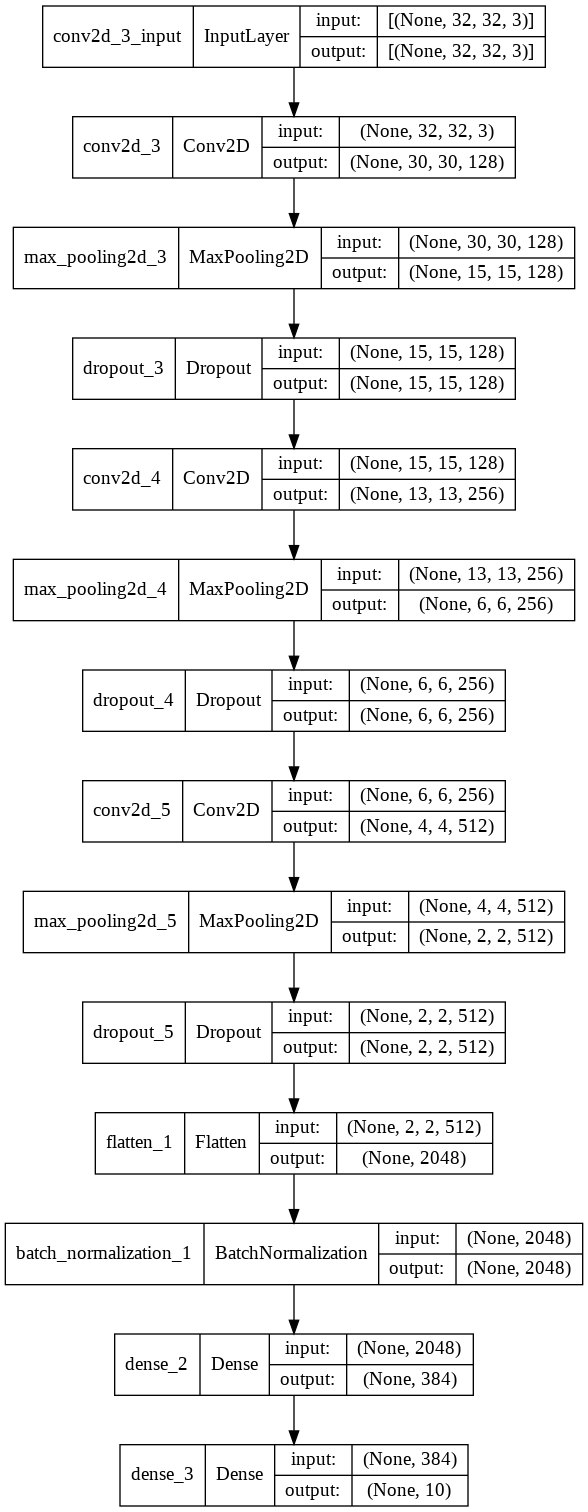

In [65]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

**Compiling the model**

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

In [66]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [67]:
history = model.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=2000
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
23/23 [==============================] - 4s 151ms/step - loss: 2.4549 - accuracy: 0.3261 - val_loss: 2.7778 - val_accuracy: 0.3590
Epoch 2/200
23/23 [==============================] - 3s 139ms/step - loss: 1.8477 - accuracy: 0.5051 - val_loss: 2.6165 - val_accuracy: 0.3600
Epoch 3/200
23/23 [==============================] - 3s 139ms/step - loss: 1.5594 - accuracy: 0.5770 - val_loss: 2.4676 - val_accuracy: 0.5436
Epoch 4/200
23/23 [==============================] - 3s 137ms/step - loss: 1.3435 - accuracy: 0.6287 - val_loss: 2.3326 - val_accuracy: 0.5864
Epoch 5/200
23/23 [==============================] - 3s 138ms/step - loss: 1.2056 - accuracy: 0.6638 - val_loss: 2.2222 - val_accuracy: 0.6184
Epoch 6/200
23/23 [==============================] - 3s 140ms/step - loss: 1.0851 - accuracy: 0.6926 - val_loss: 2.1163 - val_accuracy: 0.6634
Epoch 7/200
23/23 [==============================] - 3s 135ms/step - loss: 0.9891 - accuracy: 0.7166 - val_loss: 2.0196 - val_accuracy: 0.6762

**Validation Data**

Data on which to evaluate the loss and any model metrics at the end of each epoch

The model will not be trained on this data

**Evaluate the model**

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. 

This is easy to do, we simply use the evaluate method on our model.

In [68]:
loss, accuracy = model.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 3ms/step - loss: 0.6815 - accuracy: 0.8055
test set accuracy:  80.54999709129333


**Predictions**


In [69]:

preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


**Plotting Performance Metrics**

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.


In [70]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [71]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
25,0.396,0.893,0.657,0.809
26,0.386,0.897,0.623,0.824
27,0.375,0.901,0.618,0.823
28,0.369,0.903,0.650,0.810
29,0.355,0.907,0.654,0.815


In [72]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

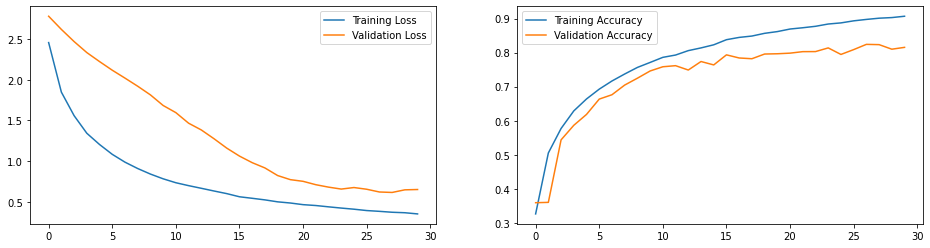

In [73]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

Confusion matrices

Using both sklearn.metrics. Then we visualize the confusion matrix and see what that tells us.

In [74]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

In [75]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1000
           1       0.92      0.88      0.90      1000
           2       0.81      0.68      0.74      1000
           3       0.65      0.66      0.65      1000
           4       0.71      0.87      0.78      1000
           5       0.78      0.67      0.72      1000
           6       0.75      0.92      0.83      1000
           7       0.89      0.81      0.85      1000
           8       0.84      0.92      0.88      1000
           9       0.88      0.88      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.80     10000
weighted avg       0.81      0.81      0.80     10000

Accuracy Score: 0.8055
Root Mean Square Error: 1.7702259742756008


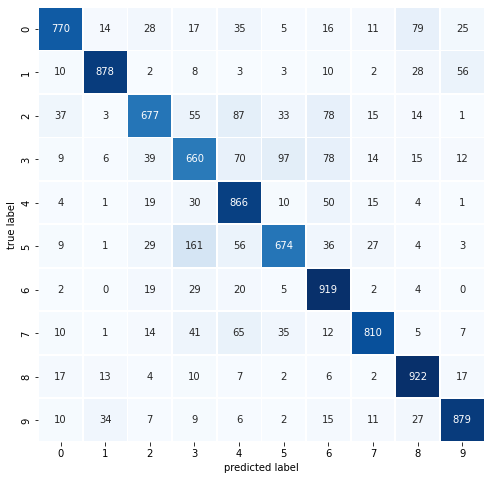

In [76]:
plot_confusion_matrix(y_test,pred1)

Load HDF5 Model Format

In [77]:
model = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/models/model_0.8120.h5')

In [78]:
preds = model.predict(x_test_norm)

preds.shape

(10000, 10)

**Predictions**

In [79]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,1.98%,0.53%,0.08%,87.32%,0.06%,7.83%,0.21%,0.30%,1.48%,0.20%
1,1.14%,1.86%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,96.94%,0.06%
2,3.30%,12.11%,0.11%,0.01%,0.00%,0.02%,0.15%,0.03%,82.33%,1.94%
3,95.00%,3.04%,0.03%,0.00%,0.00%,0.00%,0.00%,0.00%,1.88%,0.05%
4,0.00%,0.00%,0.82%,0.31%,5.06%,0.01%,93.79%,0.00%,0.00%,0.00%
5,0.00%,0.00%,0.05%,1.10%,0.74%,19.07%,78.94%,0.10%,0.01%,0.01%
6,0.06%,80.33%,0.02%,0.25%,0.00%,0.08%,0.08%,0.01%,0.03%,19.14%
7,0.35%,0.02%,16.02%,1.58%,49.59%,4.57%,27.53%,0.22%,0.03%,0.10%
8,0.00%,0.00%,0.04%,97.75%,0.82%,0.89%,0.20%,0.30%,0.00%,0.00%
9,0.13%,85.02%,0.00%,0.00%,0.00%,0.00%,0.02%,0.00%,0.14%,14.68%


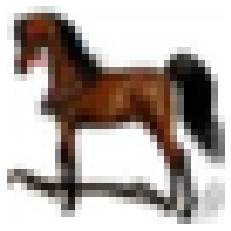

In [80]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [81]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [82]:
activations = activation_model.predict(img_tensor)
len(activations)

8

In [83]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'dropout_2',
 'flatten',
 'batch_normalization',
 'dense',
 'dense_1']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


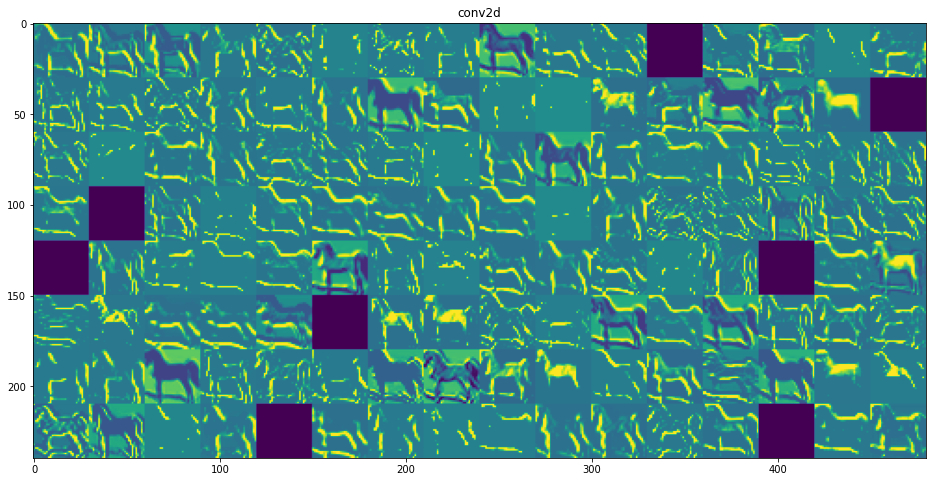

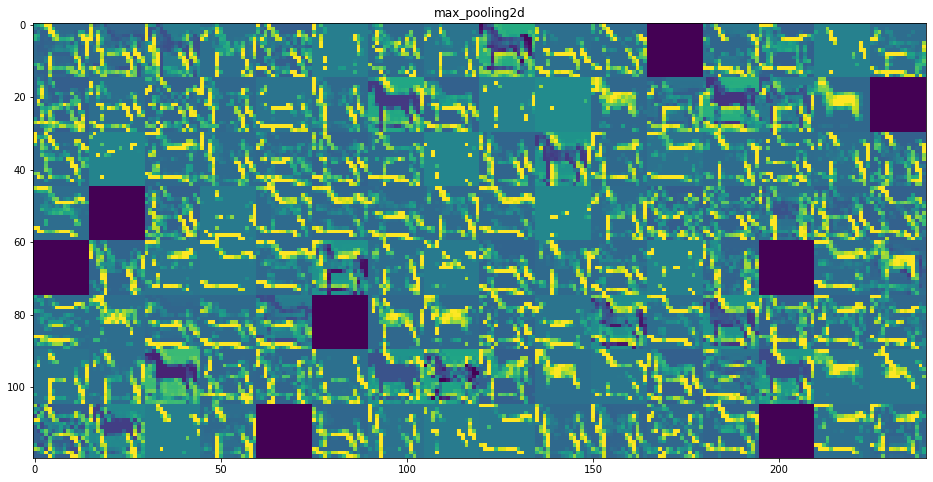

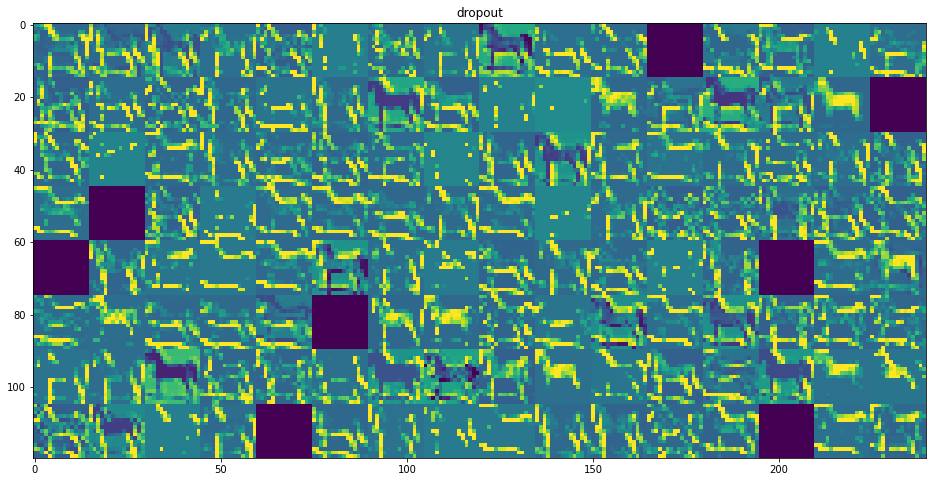

In [84]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

In [85]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_norm[:5000])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

sklearn.manifold.TSNE

In [86]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.008s...
[t-SNE] Computed neighbors for 5000 samples in 1.347s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 4.376880
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.223816
[t-SNE] KL divergence after 300 iterations: 3.185314


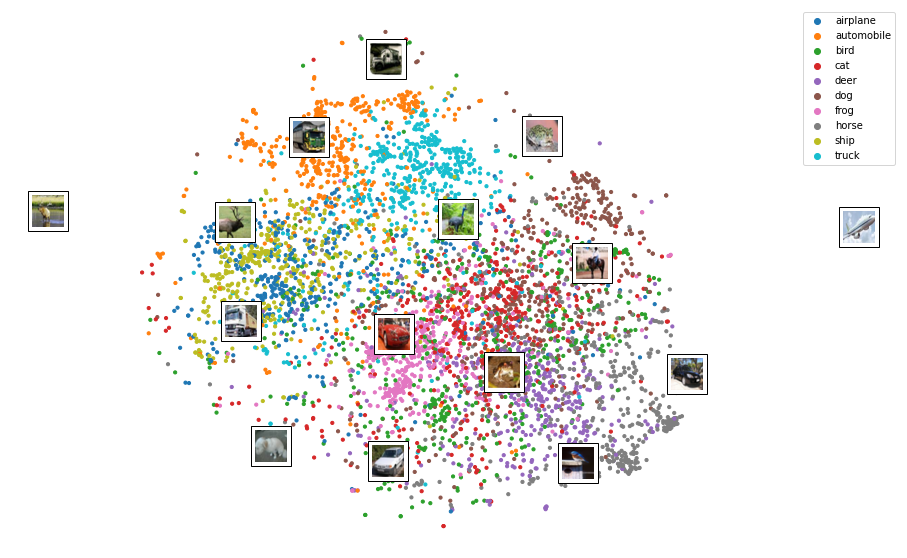

In [87]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_valid_split[:5000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()